# Training Deep Neural Networks

In [112]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from functools import partial
from scipy.special import erfc

In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Vanishing/Exploding Gradients Problem

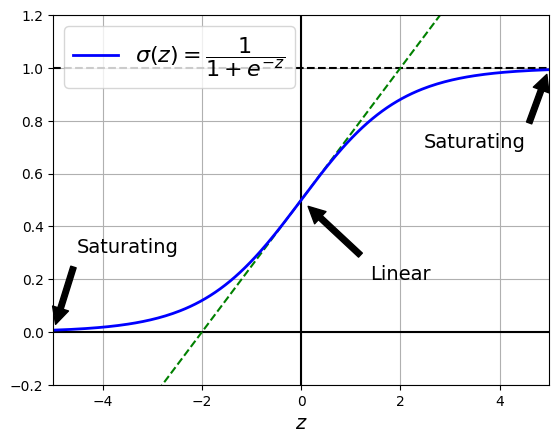

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)
plt.show()

### Xavier and He Initialization

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [7]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

### Nonsaturating Activation Functions

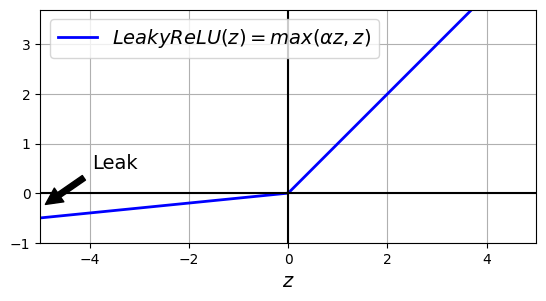

In [8]:
# Leaky ReLU

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

In [10]:
leaky_relu = tf.keras.layers.LeakyReLU(negative_slope=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [12]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(negative_slope=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [13]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

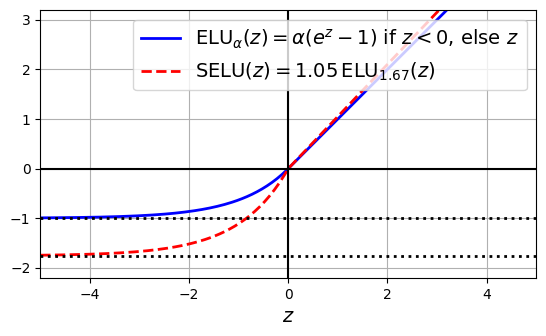

In [15]:
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

Using SELU is straightforward:

In [16]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**An example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [18]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [20]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [21]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [22]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3179 - loss: 1.7836 - val_accuracy: 0.6010 - val_loss: 0.9892
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6460 - loss: 0.9529 - val_accuracy: 0.7082 - val_loss: 0.7737
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7367 - loss: 0.7259 - val_accuracy: 0.7406 - val_loss: 0.6817
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7710 - loss: 0.6295 - val_accuracy: 0.7876 - val_loss: 0.5875
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7952 - loss: 0.5637 - val_accuracy: 0.8022 - val_loss: 0.5517


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [24]:
tf.random.set_seed(42)

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [28]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.1795 - loss: 2.1025 - val_accuracy: 0.4750 - val_loss: 1.2996
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4292 - loss: 1.3336 - val_accuracy: 0.6010 - val_loss: 0.9980
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5642 - loss: 1.0657 - val_accuracy: 0.6786 - val_loss: 0.8439
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6157 - loss: 0.9596 - val_accuracy: 0.6552 - val_loss: 0.9059
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6603 - loss: 0.8479 - val_accuracy: 0.6700 - val_loss: 0.8498


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

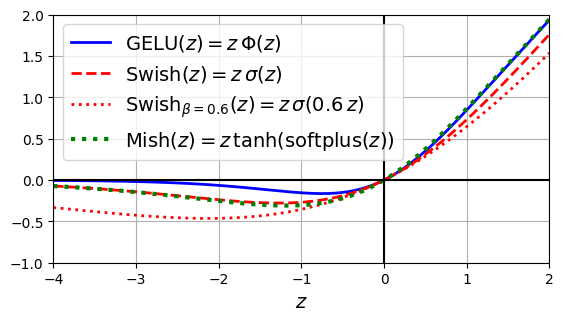

In [29]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")
plt.show()

### Batch Normalization

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [32]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [33]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [34]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

In [35]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step - accuracy: 0.7544 - loss: 0.7246 - val_accuracy: 0.8580 - val_loss: 0.3910
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.8563 - loss: 0.4039 - val_accuracy: 0.8698 - val_loss: 0.3589


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [36]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [38]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [39]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.7348 - loss: 0.8126 - val_accuracy: 0.8434 - val_loss: 0.4318
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.8450 - loss: 0.4402 - val_accuracy: 0.8612 - val_loss: 0.3926


### Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [40]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [41]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

**Using Norm is more recommended cause of the preservation of momentum**

### Reusing Pretrained Layers

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [43]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A.keras")

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.5197 - loss: 1.4766 - val_accuracy: 0.7884 - val_loss: 0.6801
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - accuracy: 0.7969 - loss: 0.6359 - val_accuracy: 0.8355 - val_loss: 0.5094
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step - accuracy: 0.8411 - loss: 0.4999 - val_accuracy: 0.8554 - val_loss: 0.4395
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - accuracy: 0.8587 - loss: 0.4360 - val_accuracy: 0.8651 - val_loss: 0.3979
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step - accuracy: 0.8696 - loss: 0.3962 - val_accuracy: 0.8759 - val_loss: 0.3702
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step - accuracy: 0.8763 - loss: 0.3687 - val_accuracy: 0.8802 - val_loss: 0.3502
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step - accuracy: 0.8825 - loss: 0.3484 - val_accuracy: 0.8854 - val_loss: 0.3352
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - accuracy: 0.8880 -

In [44]:
tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4391 - loss: 0.6854 - val_accuracy: 0.5035 - val_loss: 0.6519
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4740 - loss: 0.6540 - val_accuracy: 0.5569 - val_loss: 0.6288
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5310 - loss: 0.6288 - val_accuracy: 0.6429 - val_loss: 0.6097
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7158 - loss: 0.6076 - val_accuracy: 0.7221 - val_loss: 0.5932
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7547 - loss: 0.5897 - val_accuracy: 0.7695 - val_loss: 0.5784
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8178 - loss: 0.5737 - val_accuracy: 0.8042 - val_loss: 0.5646
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8318 - loss: 0.5588 - val_accuracy: 0.8259 - val_loss: 0.5516
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8519 - loss: 0.5448 - val_accuracy: 0.8427 - val_loss: 0.5392
Epoch 9

[0.429994136095047, 0.9179999828338623]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [45]:
model_A = tf.keras.models.load_model("my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [46]:
tf.random.set_seed(42)

In [47]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [48]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [49]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [50]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5608 - loss: 0.8250 - val_accuracy: 0.5598 - val_loss: 0.7367
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6211 - loss: 0.7157 - val_accuracy: 0.5846 - val_loss: 0.7118
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6039 - loss: 0.6983 - val_accuracy: 0.5885 - val_loss: 0.6996
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6216 - loss: 0.6861 - val_accuracy: 0.5955 - val_loss: 0.6886
Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6475 - loss: 0.6582 - val_accuracy: 0.6954 - val_loss: 0.6128
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7393 - loss: 0.5780 - val_accuracy: 0.7428 - val_loss: 0.5552
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7961 - loss: 0.5164 - val_accuracy: 0.7933 - val_loss: 0.5107
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8294 - loss: 0.4692 - val_accuracy: 0.8140 - val_loss: 0.4750
Epoch 5/16

So, what's the final verdict?

In [51]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.9160 - loss: 0.2862


[0.2872675061225891, 0.9100000262260437]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%:

In [52]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

### Faster Optimizers

In [56]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.Input(shape=[28, 28]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [57]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [58]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6512 - loss: 1.0288 - val_accuracy: 0.8164 - val_loss: 0.5018
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - accuracy: 0.8279 - loss: 0.4876 - val_accuracy: 0.8322 - val_loss: 0.4521
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - accuracy: 0.8466 - loss: 0.4343 - val_accuracy: 0.8416 - val_loss: 0.4245
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - accuracy: 0.8572 - loss: 0.4031 - val_accuracy: 0.8488 - val_loss: 0.4084
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - accuracy: 0.8648 - loss: 0.3814 - val_accuracy: 0.8538 - val_loss: 0.3963
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - accuracy: 0.8707 - loss: 0.3644 - val_accuracy: 0.8586 - val_loss: 0.3854
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step - accuracy: 0.8755 - loss: 0.3501 - val_accuracy: 0.8592 - val_loss: 0.3770
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.8793 -

### Momentum optimization

In [59]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [60]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6669 - loss: 1.0097 - val_accuracy: 0.8230 - val_loss: 0.4984
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - accuracy: 0.8340 - loss: 0.4805 - val_accuracy: 0.8346 - val_loss: 0.4488
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - accuracy: 0.8501 - loss: 0.4287 - val_accuracy: 0.8470 - val_loss: 0.4189
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - accuracy: 0.8598 - loss: 0.3993 - val_accuracy: 0.8542 - val_loss: 0.3994
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - accuracy: 0.8659 - loss: 0.3790 - val_accuracy: 0.8570 - val_loss: 0.3908
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step - accuracy: 0.8713 - loss: 0.3627 - val_accuracy: 0.8590 - val_loss: 0.3833
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - accuracy: 0.8756 - loss: 0.3493 - val_accuracy: 0.8612 - val_loss: 0.3777
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step - accuracy: 0.8798 -

### Nesterov Accelerated Gradient

In [61]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [62]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.6795 - loss: 0.9597 - val_accuracy: 0.8226 - val_loss: 0.4923
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - accuracy: 0.8316 - loss: 0.4782 - val_accuracy: 0.8388 - val_loss: 0.4491
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.8485 - loss: 0.4274 - val_accuracy: 0.8496 - val_loss: 0.4229
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8578 - loss: 0.3971 - val_accuracy: 0.8524 - val_loss: 0.4079
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - accuracy: 0.8657 - loss: 0.3754 - val_accuracy: 0.8548 - val_loss: 0.3995
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - accuracy: 0.8706 - loss: 0.3592 - val_accuracy: 0.8586 - val_loss: 0.3878
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8754 - loss: 0.3454 - val_accuracy: 0.8588 - val_loss: 0.3859
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - accuracy: 0.8794 -

### AdaGrad

In [63]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [64]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - accuracy: 0.5828 - loss: 1.3401 - val_accuracy: 0.7806 - val_loss: 0.6803
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.7841 - loss: 0.6643 - val_accuracy: 0.8052 - val_loss: 0.5858
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8068 - loss: 0.5855 - val_accuracy: 0.8150 - val_loss: 0.5454
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8174 - loss: 0.5474 - val_accuracy: 0.8250 - val_loss: 0.5192
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.8250 - loss: 0.5215 - val_accuracy: 0.8280 - val_loss: 0.5012
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8309 - loss: 0.5027 - val_accuracy: 0.8318 - val_loss: 0.4874
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.8353 - loss: 0.4885 - val_accuracy: 0.8344 - val_loss: 0.4764
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - accuracy: 0.8395 -

### RMSProp

In [65]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [66]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - accuracy: 0.7624 - loss: 0.6628 - val_accuracy: 0.8344 - val_loss: 0.4290
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 529us/step - accuracy: 0.8548 - loss: 0.4033 - val_accuracy: 0.8368 - val_loss: 0.4412
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.8694 - loss: 0.3671 - val_accuracy: 0.8500 - val_loss: 0.4278
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - accuracy: 0.8748 - loss: 0.3549 - val_accuracy: 0.8338 - val_loss: 0.4997
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - accuracy: 0.8809 - loss: 0.3463 - val_accuracy: 0.8288 - val_loss: 0.5371
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - accuracy: 0.8832 - loss: 0.3420 - val_accuracy: 0.8454 - val_loss: 0.4685
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.8836 - loss: 0.3395 - val_accuracy: 0.8240 - val_loss: 0.6827
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step - accuracy: 0.8868 -

### Adam Optimization

In [67]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [68]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 709us/step - accuracy: 0.7733 - loss: 0.6428 - val_accuracy: 0.8330 - val_loss: 0.4209
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - accuracy: 0.8588 - loss: 0.3871 - val_accuracy: 0.8456 - val_loss: 0.3902
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - accuracy: 0.8734 - loss: 0.3426 - val_accuracy: 0.8524 - val_loss: 0.3932
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.8830 - loss: 0.3164 - val_accuracy: 0.8576 - val_loss: 0.3801
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.8892 - loss: 0.2972 - val_accuracy: 0.8648 - val_loss: 0.3543
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - accuracy: 0.8967 - loss: 0.2790 - val_accuracy: 0.8740 - val_loss: 0.3457
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - accuracy: 0.9000 - loss: 0.2664 - val_accuracy: 0.8698 - val_loss: 0.3616
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.9035 -

**Adamax Optimization**

In [69]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [70]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.7610 - loss: 0.7041 - val_accuracy: 0.8412 - val_loss: 0.4297
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.8549 - loss: 0.4104 - val_accuracy: 0.8554 - val_loss: 0.3857
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - accuracy: 0.8688 - loss: 0.3664 - val_accuracy: 0.8632 - val_loss: 0.3696
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - accuracy: 0.8778 - loss: 0.3386 - val_accuracy: 0.8662 - val_loss: 0.3581
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - accuracy: 0.8848 - loss: 0.3178 - val_accuracy: 0.8650 - val_loss: 0.3611
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.8900 - loss: 0.3017 - val_accuracy: 0.8668 - val_loss: 0.3578
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - accuracy: 0.8949 - loss: 0.2880 - val_accuracy: 0.8702 - val_loss: 0.3521
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.8998 -

**Nadam Optimization**

In [71]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [72]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 847us/step - accuracy: 0.7817 - loss: 0.6233 - val_accuracy: 0.8460 - val_loss: 0.4026
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.8618 - loss: 0.3809 - val_accuracy: 0.8522 - val_loss: 0.3825
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.8749 - loss: 0.3407 - val_accuracy: 0.8492 - val_loss: 0.3858
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.8843 - loss: 0.3138 - val_accuracy: 0.8550 - val_loss: 0.3820
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.8937 - loss: 0.2926 - val_accuracy: 0.8520 - val_loss: 0.4139
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.8954 - loss: 0.2787 - val_accuracy: 0.8602 - val_loss: 0.3838
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.9020 - loss: 0.2647 - val_accuracy: 0.8632 - val_loss: 0.3769
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.9051 -

**AdamW Optimization**

Note: Since TF 1.12, `AdamW` is no longer experimental. It is available at `tf.keras.optimizers.AdamW` instead of `tf.keras.optimizers.experimental.AdamW`.

In [73]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [74]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 672us/step - accuracy: 0.7732 - loss: 0.6365 - val_accuracy: 0.8270 - val_loss: 0.4401
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - accuracy: 0.8596 - loss: 0.3859 - val_accuracy: 0.8342 - val_loss: 0.4241
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.8754 - loss: 0.3412 - val_accuracy: 0.8522 - val_loss: 0.3992
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - accuracy: 0.8831 - loss: 0.3169 - val_accuracy: 0.8586 - val_loss: 0.3718
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - accuracy: 0.8928 - loss: 0.2941 - val_accuracy: 0.8638 - val_loss: 0.3942
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - accuracy: 0.8974 - loss: 0.2778 - val_accuracy: 0.8712 - val_loss: 0.3736
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.9007 - loss: 0.2672 - val_accuracy: 0.8708 - val_loss: 0.3830
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - accuracy: 0.9048 -

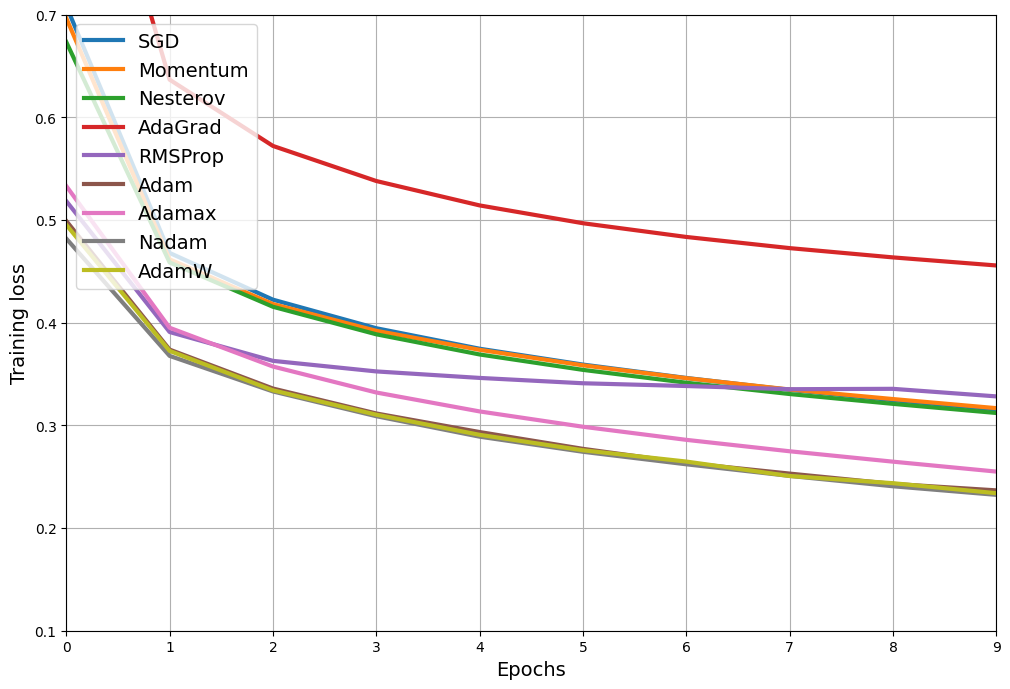

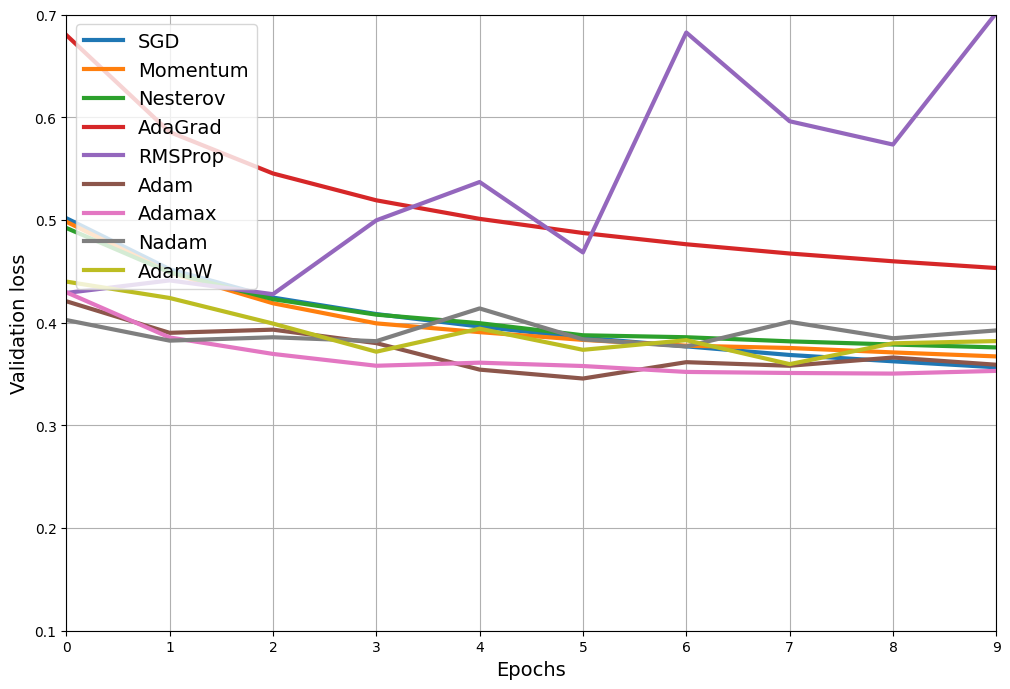

In [75]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

### Learning Rate Scheduling

### Power Scheduling

```python
learning_rate = initial_learning_rate / (1 + step / decay_steps)**power
```

Keras uses `power = 1`.

**Note**: Optimizers used to have a `decay` argument for this, but it was deprecated. You must use the schedulers in `tf.keras.optimizers.schedules` instead.

In [76]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

The `InverseTimeDecay` scheduler uses `learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)`. If you set `staircase=True`, then it replaces `step / decay_step` with `floor(step / decay_step)`.

In [77]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.6803 - loss: 0.9492 - val_accuracy: 0.8294 - val_loss: 0.4900
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - accuracy: 0.8307 - loss: 0.4871 - val_accuracy: 0.8354 - val_loss: 0.4528
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step - accuracy: 0.8465 - loss: 0.4362 - val_accuracy: 0.8398 - val_loss: 0.4355
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - accuracy: 0.8552 - loss: 0.4080 - val_accuracy: 0.8434 - val_loss: 0.4212
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - accuracy: 0.8623 - loss: 0.3885 - val_accuracy: 0.8482 - val_loss: 0.4103
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy: 0.8669 - loss: 0.3741 - val_accuracy: 0.8524 - val_loss: 0.4020
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - accuracy: 0.8707 - loss: 0.3623 - val_accuracy: 0.8552 - val_loss: 0.3955
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - accuracy: 0.8747 -

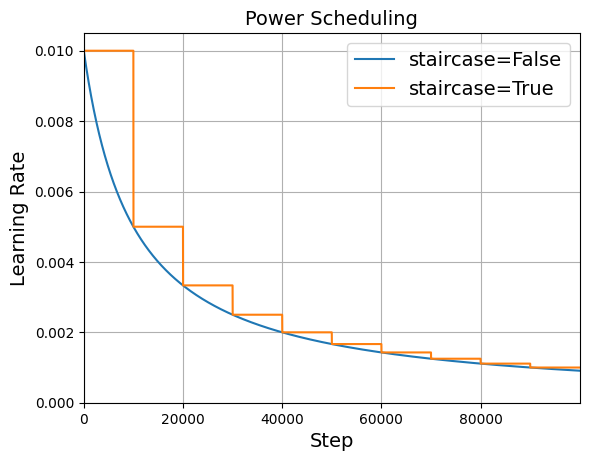

In [78]:
initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Exponential Scheduling

```python
learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)
```

In [79]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [80]:
history_exponential_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.6875 - loss: 0.9246 - val_accuracy: 0.8254 - val_loss: 0.4873
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step - accuracy: 0.8297 - loss: 0.4850 - val_accuracy: 0.8412 - val_loss: 0.4411
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.8468 - loss: 0.4345 - val_accuracy: 0.8500 - val_loss: 0.4190
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step - accuracy: 0.8568 - loss: 0.4079 - val_accuracy: 0.8548 - val_loss: 0.4034
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step - accuracy: 0.8625 - loss: 0.3903 - val_accuracy: 0.8542 - val_loss: 0.3932
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - accuracy: 0.8671 - loss: 0.3775 - val_accuracy: 0.8582 - val_loss: 0.3850
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy: 0.8699 - loss: 0.3679 - val_accuracy: 0.8598 - val_loss: 0.3786
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - accuracy: 0.8731 -

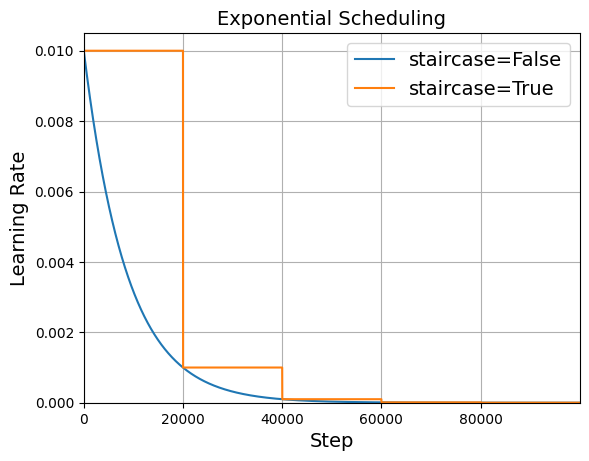

In [81]:
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras also provides a `LearningRateScheduler` callback class that lets you define your own scheduling function. Let's see how you could use it to implement exponential decay. Note that in this case the learning rate only changes at each epoch, not at each step:

In [82]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [83]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [84]:
tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [85]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - accuracy: 0.6787 - loss: 0.9754 - val_accuracy: 0.8274 - val_loss: 0.4872 - learning_rate: 0.0100
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - accuracy: 0.8309 - loss: 0.4848 - val_accuracy: 0.8410 - val_loss: 0.4464 - learning_rate: 0.0089
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - accuracy: 0.8483 - loss: 0.4322 - val_accuracy: 0.8452 - val_loss: 0.4294 - learning_rate: 0.0079
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - accuracy: 0.8579 - loss: 0.4023 - val_accuracy: 0.8476 - val_loss: 0.4224 - learning_rate: 0.0071
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - accuracy: 0.8638 - loss: 0.3822 - val_accuracy: 0.8512 - val_loss: 0.4111 - learning_rate: 0.0063
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step - accuracy: 0.8689 - loss: 0.3670 - val_accuracy: 0.8550 - val_loss: 0.4005 - learning_rate: 0.0056
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accura

Alternatively, the schedule function can take the current learning rate as a second argument:

In [86]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

### Piecewise Constant Scheduling

In [87]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [88]:
history_piecewise_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6753 - loss: 0.9536 - val_accuracy: 0.8294 - val_loss: 0.4821
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - accuracy: 0.8306 - loss: 0.4867 - val_accuracy: 0.8398 - val_loss: 0.4387
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 412us/step - accuracy: 0.8488 - loss: 0.4323 - val_accuracy: 0.8468 - val_loss: 0.4174
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - accuracy: 0.8591 - loss: 0.4015 - val_accuracy: 0.8504 - val_loss: 0.4017
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - accuracy: 0.8645 - loss: 0.3796 - val_accuracy: 0.8550 - val_loss: 0.3918
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step - accuracy: 0.8702 - loss: 0.3628 - val_accuracy: 0.8592 - val_loss: 0.3837
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - accuracy: 0.8750 - loss: 0.3486 - val_accuracy: 0.8626 - val_loss: 0.3790
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - accuracy: 0.8789 -

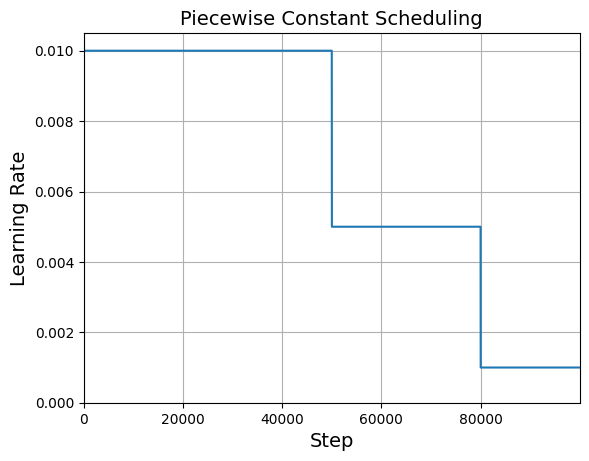

In [89]:
boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

We've looked at `InverseTimeDecay`, `ExponentialDecay`, and `PiecewiseConstantDecay`. A few more schedulers are available in `tf.keras.optimizers.schedules`, here is the full list:

In [93]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A `LearningRateSchedule` that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A `LearningRateSchedule` that uses a cosine decay schedule with restarts.
• ExponentialDecay – A `LearningRateSchedule` that uses an exponential decay schedule.
• InverseTimeDecay – A `LearningRateSchedule` that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A `LearningRateSchedule` that uses a piecewise constant decay schedule.
• PolynomialDecay – A `LearningRateSchedule` that uses a polynomial decay schedule.


### Performance Scheduling

In [94]:
lr0 = 0.01

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [95]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step - accuracy: 0.6810 - loss: 0.9536 - val_accuracy: 0.8230 - val_loss: 0.4884 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - accuracy: 0.8274 - loss: 0.4930 - val_accuracy: 0.8352 - val_loss: 0.4434 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - accuracy: 0.8459 - loss: 0.4384 - val_accuracy: 0.8440 - val_loss: 0.4244 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - accuracy: 0.8568 - loss: 0.4070 - val_accuracy: 0.8488 - val_loss: 0.4117 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step - accuracy: 0.8628 - loss: 0.3855 - val_accuracy: 0.8498 - val_loss: 0.4023 - learning_rate: 0.0100
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - accuracy: 0.8693 - loss: 0.3681 - val_accuracy: 0.8510 - val_loss: 0.3990 - learning_rate: 0.0100
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - accura

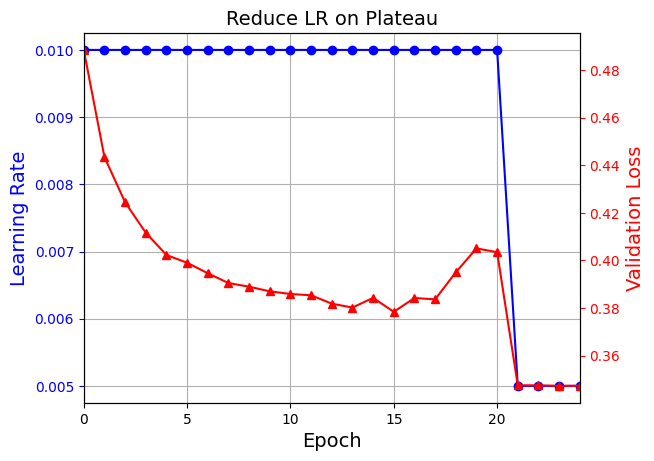

In [96]:
plt.plot(history.epoch, history.history["learning_rate"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [102]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        lr = self.model.optimizer.learning_rate.numpy()
        self.rates.append(lr)
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = lr * self.factor

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [104]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    _ = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [105]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [106]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.2371 - loss: 2.1083


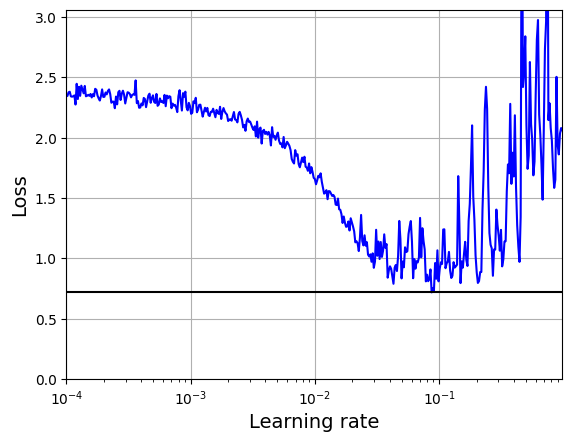

In [107]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [108]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [109]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.5719 - loss: 1.3491 - val_accuracy: 0.7860 - val_loss: 0.6079
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.7864 - loss: 0.6068 - val_accuracy: 0.8192 - val_loss: 0.5158
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.8172 - loss: 0.5184 - val_accuracy: 0.8330 - val_loss: 0.4766
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.8349 - loss: 0.4704 - val_accuracy: 0.8346 - val_loss: 0.4690
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.8437 - loss: 0.4382 - val_accuracy: 0.8400 - val_loss: 0.4363
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.8511 - loss: 0.4121 - val_accuracy: 0.8410 - val_loss: 0.4339
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.8572 - loss: 0.3916 - val_accuracy: 0.8438 - val_loss: 0.4274
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.8632 - loss: 0.3753 - 

### Avoiding Overfitting Through Regularization

### $\ell_1$ and $\ell_2$ regularization

In [110]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [111]:
tf.random.set_seed(42)

In [114]:
RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [115]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - accuracy: 0.7110 - loss: 4.0599 - val_accuracy: 0.8222 - val_loss: 1.8558
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step - accuracy: 0.8119 - loss: 1.6219 - val_accuracy: 0.8220 - val_loss: 1.1186


### Dropout

In [116]:
tf.random.set_seed(42)

In [118]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [119]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.6779 - loss: 0.8888 - val_accuracy: 0.8376 - val_loss: 0.4460
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8058 - loss: 0.5317 - val_accuracy: 0.8472 - val_loss: 0.4167
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.8239 - loss: 0.4875 - val_accuracy: 0.8520 - val_loss: 0.3988
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - accuracy: 0.8321 - loss: 0.4626 - val_accuracy: 0.8548 - val_loss: 0.3850
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.8360 - loss: 0.4495 - val_accuracy: 0.8586 - val_loss: 0.3722
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.8413 - loss: 0.4324 - val_accuracy: 0.8570 - val_loss: 0.3771
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.8444 - loss: 0.4212 - val_accuracy: 0.8650 - val_loss: 0.3641
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.8484 -

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [120]:
model.evaluate(X_train, y_train)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.8821 - loss: 0.3150


[0.3192124664783478, 0.8815454840660095]

In [121]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - accuracy: 0.8670 - loss: 0.3738


[0.37519845366477966, 0.8629999756813049]

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## Max norm

In [126]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [127]:
MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.7439 - loss: 0.7217 - val_accuracy: 0.8302 - val_loss: 0.4366
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.8464 - loss: 0.4234 - val_accuracy: 0.8470 - val_loss: 0.4014
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.8588 - loss: 0.3840 - val_accuracy: 0.8548 - val_loss: 0.3863
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8656 - loss: 0.3631 - val_accuracy: 0.8482 - val_loss: 0.3960
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.8703 - loss: 0.3477 - val_accuracy: 0.8534 - val_loss: 0.3865
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.8738 - loss: 0.3382 - val_accuracy: 0.8596 - val_loss: 0.3756
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step - accuracy: 0.8773 - loss: 0.3308 - val_accuracy: 0.8526 - val_loss: 0.3802
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.8790 -

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.*

In [117]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [118]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [119]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [120]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [121]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model.keras",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [123]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 17s 10ms/step - loss: 4.0462 - accuracy: 0.1597 - val_loss: 2.1441 - val_accuracy: 0.2036
Epoch 2/100
1407/1407 [==============================] - 12s 9ms/step - loss: 2.0667 - accuracy: 0.2320 - val_loss: 2.0134 - val_accuracy: 0.2472
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.9472 - accuracy: 0.2819 - val_loss: 1.9427 - val_accuracy: 0.2796
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8637 - accuracy: 0.3182 - val_loss: 1.8934 - val_accuracy: 0.3222
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7974 - accuracy: 0.3465 - val_loss: 1.8389 - val_accuracy: 0.3284
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.7446 - accuracy: 0.3664 - val_loss: 2.0006 - val_accuracy: 0.3030
Epoch 7/100
1407/1407 [==============================] - 12s 8ms/step - loss: 1.6974 - accuracy: 0.3852 - val_loss: 1.707

In [124]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5062 - accuracy: 0.4676


[1.5061508417129517, 0.4675999879837036]

The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to `my_cifar10_bn_model`.

In [125]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.keras",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 32s 18ms/step - loss: 2.0374 - accuracy: 0.2525 - val_loss: 1.8766 - val_accuracy: 0.3154
Epoch 2/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7874 - accuracy: 0.3542 - val_loss: 1.8784 - val_accuracy: 0.3268
Epoch 3/100
1407/1407 [==============================] - 20s 15ms/step - loss: 1.6806 - accuracy: 0.3969 - val_loss: 1.9764 - val_accuracy: 0.3252
Epoch 4/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6112 - accuracy: 0.4228 - val_loss: 1.7087 - val_accuracy: 0.3750
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5521 - accuracy: 0.4476 - val_loss: 1.6272 - val_accuracy: 0.4176
Epoch 6/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5030 - accuracy: 0.4660 - val_loss: 1.5401 - val_accuracy: 0.4452
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.4559 - accuracy: 0.4812 - val_loss: 1

[1.4236289262771606, 0.5073999762535095]

* *Is the model converging faster than before?* Much faster! The previous model took 29 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 12 epochs and continued to make progress until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 50.7% validation accuracy instead of 46.7%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [126]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model.keras", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 20s 13ms/step - loss: 1.9385 - accuracy: 0.3046 - val_loss: 1.8175 - val_accuracy: 0.3510
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7241 - accuracy: 0.3869 - val_loss: 1.7677 - val_accuracy: 0.3614
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6272 - accuracy: 0.4263 - val_loss: 1.6878 - val_accuracy: 0.4054
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5643 - accuracy: 0.4492 - val_loss: 1.6589 - val_accuracy: 0.4304
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5080 - accuracy: 0.4712 - val_loss: 1.5651 - val_accuracy: 0.4538
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4613 - accuracy: 0.4872 - val_loss: 1.5305 - val_accuracy: 0.4678
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4174 - accuracy: 0.5077 - val_loss: 1

[1.4607702493667603, 0.5026000142097473]

This model reached the first model's validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 50.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it's the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

**Warning**: there are now two versions of `AlphaDropout`. One is deprecated and also broken in some recent versions of TF, and unfortunately that's the version in the `tensorflow` library. Luckily, there's a perfectly fine version in the `keras` library (i.e., `keras`, not `tf.keras`). It's neither deprecated nor broken, so let's import and use that one:

In [127]:
import keras.layers

In [128]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model.keras", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 18s 11ms/step - loss: 1.8950 - accuracy: 0.3239 - val_loss: 1.7556 - val_accuracy: 0.3812
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6618 - accuracy: 0.4130 - val_loss: 1.6563 - val_accuracy: 0.4114
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5770 - accuracy: 0.4432 - val_loss: 1.6507 - val_accuracy: 0.4232
Epoch 4/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.5081 - accuracy: 0.4672 - val_loss: 1.5892 - val_accuracy: 0.4566
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4561 - accuracy: 0.4902 - val_loss: 1.5382 - val_accuracy: 0.4696
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4094 - accuracy: 0.5050 - val_loss: 1.5236 - val_accuracy: 0.4818
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3636 - accuracy: 0.5232 - val_loss: 1

[1.4779616594314575, 0.498199999332428]

The model reaches 48.1% accuracy on the validation set. That's worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [129]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [130]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [131]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [132]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

0.4984

We get back to roughly the accuracy of the model without dropout in this case (about 50.3% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [133]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 3s 8ms/step - loss: nan - accuracy: 0.1706


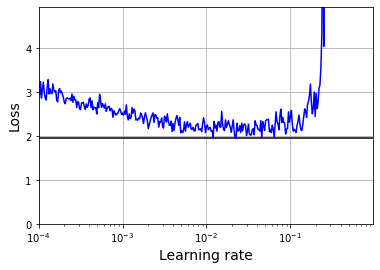

In [134]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [135]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [136]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 9ms/step - loss: 2.0559 - accuracy: 0.2839 - val_loss: 1.7917 - val_accuracy: 0.3768
Epoch 2/15
352/352 [==============================] - 3s 8ms/step - loss: 1.7596 - accuracy: 0.3797 - val_loss: 1.6566 - val_accuracy: 0.4258
Epoch 3/15
352/352 [==============================] - 3s 8ms/step - loss: 1.6199 - accuracy: 0.4247 - val_loss: 1.6395 - val_accuracy: 0.4260
Epoch 4/15
352/352 [==============================] - 3s 9ms/step - loss: 1.5451 - accuracy: 0.4524 - val_loss: 1.6202 - val_accuracy: 0.4408
Epoch 5/15
352/352 [==============================] - 3s 8ms/step - loss: 1.4952 - accuracy: 0.4691 - val_loss: 1.5981 - val_accuracy: 0.4488
Epoch 6/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4541 - accuracy: 0.4842 - val_loss: 1.5720 - val_accuracy: 0.4490
Epoch 7/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4171 - accuracy: 0.4967 - val_loss: 1.6035 - val_accuracy: 0.4470
Epoch 

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.7% to 52.0%).